<a href="https://colab.research.google.com/github/mohansameer1983/DeepLearning/blob/main/20309780_Mohan_Sameer_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 894 - Exercise 3
## Transfer learning with DistilBert
The goal of this excercise is to build a text classifier using the pretrained DistilBert published by HuggingFace. You will be doing this using the Glue/CoLA dataset (https://nyu-mll.github.io/CoLA/).

Submission instructions:

- You cannot edit this notebook directly. Save a copy to your drive, and make sure to identify yourself in the title using name and student number
- Do not insert new cells before the final one (titled "Further exploration") 
- Verify that your notebook can _restart and run all_. 
- Unlike previous assignments, please **submit all three formats: .py, .ipynb, and html** (see https://torbjornzetterlund.com/how-to-save-a-google-colab-notebook-as-html/)
 - The notebook and html submissions should show the completion of your best performing run
 - Submission files should be named: `studentID_lastname_firstname_ex3.py (or .html, .ipynb)`
- The mark will be assessed on the implementation of the functions with #TODO
- **Do not change anything outside the functions**  unless in the further exploration section
- - As you are encouraged to explore the network configuration, 20% of the mark is based on final accuracy. 
- Note: You do not have to answer the questions in thie notebook as part of your submission. They are meant to guide you.

- You should not need to use any additional libraries other than the ones listed below. You may want to import additional modules from those libraries, however.

In [1]:
# This cell installs and sets up DistilBert import, as well as the dataset, which we will 
# use tf.datasets to load (https://www.tensorflow.org/datasets/catalog/overview)

!pip install -q transformers tfds-nightly

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd

try: # this is only working on the 2nd try in colab :)
  from transformers import DistilBertTokenizer, TFDistilBertModel
except Exception as err: # so we catch the error and import it again
  from transformers import DistilBertTokenizer, TFDistilBertModel

import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds

dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

import re

     |████████████████████████████████| 3.5 MB 4.3 MB/s 
     |████████████████████████████████| 4.2 MB 25.5 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 6.8 MB 37.4 MB/s 
     |████████████████████████████████| 895 kB 48.0 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
     |████████████████████████████████| 76 kB 4.4 MB/s 


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Data Preparation

In [2]:
def load_data(save_dir="./"):
  dataset = tfds.load('glue/cola', shuffle_files=True)
  train = tfds.as_dataframe(dataset["train"])
  val = tfds.as_dataframe(dataset["validation"])
  test = tfds.as_dataframe(dataset["test"])
  return train, val, test

def prepare_raw_data(df):
  raw_data = df.loc[:, ["idx", "sentence", "label"]]
  raw_data["label"] = raw_data["label"].astype('category')
  return raw_data

train, val, test = load_data()
train = prepare_raw_data(train)
val = prepare_raw_data(val)
test = prepare_raw_data(test)

num_classes=len(train.label.unique())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8551 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/cola/2.0.0.incompleteUUC5NE/glue-train.tfrecord*...:   0%|          | 0/8…

Generating validation examples...:   0%|          | 0/1043 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/cola/2.0.0.incompleteUUC5NE/glue-validation.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1063 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/cola/2.0.0.incompleteUUC5NE/glue-test.tfrecord*...:   0%|          | 0/10…

Dataset glue downloaded and prepared to ~/tensorflow_datasets/glue/cola/2.0.0. Subsequent calls will reuse this data.


Before using this data, we need to clean and QA it. Unlike MNIST, this is a text dataset, and we should be more caerful. For example:
- Are there any duplicate entries? 
- What is the range of lengths for the sentences? Should we impose a minimum sentence length?
- Are there "non-sentence" entries? For example, hashtags or other features we should remove? (luckily, this dataset is quite clean, but that might not always be the case!)

NOTE! The sentences are encoded as binary strings. To do text manipulations, you might need to decode them using `s.decode("utf-8")`

You may notice that that test set has no labels. This is because Glue is a benchmark dataset, and only gets scored on submissions.

In [3]:
def clean_data(df):
#   # TODO: What data cleaning/filtering should you consider?
#   # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

  #df["sentence_string"]=df["sentence"].astype(str)
  for ind in df.index:
    
    string = df["sentence"][ind].decode("utf-8")
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    df["sentence"][ind]=string.encode("utf-8")
  return df

print(train)
train = clean_data(train)
val = clean_data(val)
test = clean_data(test)

print(train.head())
print(test.head())

       idx                                           sentence label
0     1680  b'It is this hat that it is certain that he wa...     1
1     1456  b'Her efficient looking up of the answer pleas...     1
2     4223          b'Both the workers will wear carnations.'     1
3     4093  b'John enjoyed drawing trees for his syntax ho...     1
4     7111  b'We consider Leslie rather foolish, and Lou a...     1
...    ...                                                ...   ...
8546  4920              b'a pencil with that to write broke.'     0
8547  3619  b'It was in the park last night that the polic...     0
8548  3624       b'John looked up the inside of the chimney.'     1
8549  8351                     b'You said she liked yourself'     0
8550  5073    b"What we're using is their teaching material."     1

[8551 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


    idx                                           sentence label
0  1680  b'it this hat that it certain that he was wear...     1
1  1456  b'her efficient looking up of answer pleased b...     1
2  4223                    b'both workers wear carnations'     1
3  4093  b'john enjoyed drawing trees for his syntax ho...     1
4  7111  b'we consider leslie rather foolish lou comple...     1
    idx                                       sentence label
0   163               b'brian was wiping behind stove'    -1
1   131          b'you could give headache to tylenol'    -1
2  1021                         b'i want to meet at 6'    -1
3   166                       b'packages carry easily'    -1
4  1039  b'many people said they were sick who werent'    -1


Next, we need to prepare the text for DistilBert. Instead of ingesting raw text, the model uses token IDs to map to internal embedding. Additionally, since the input is fixed size (due to our use of batches), we need to let the model know which tokens to use (i.e. are part of the sentence).

Luckily, `dbert_tokenizer` takes care of all that for us - 
- Preprocessing: https://huggingface.co/transformers/preprocessing.html
- Summary of tokenizers (DistilBert uses WordPiece): https://huggingface.co/transformers/tokenizer_summary.html#wordpiece

In [4]:
def extract_text_and_y(df):
  text = [x.decode('utf-8') for x in  df.sentence.values]
  # for multiclass problems, you can use sklearn.preprocessing.OneHotEncoder, but we only have two classes, so we'll use a single sigmoid output
  y = np.array([x for x in df.label.values])
  return text, y

def encode_text(text):
    # TODO: encode text using dbert_tokenizer
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    # Encode the sentence
    encodedText = dbert_tokenizer.batch_encode_plus(
        batch_text_or_text_pairs=text,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 24,
        padding='max_length',
        truncation=True
        )

    # Get the input IDs and attention mask in tensor format
    input_ids = tf.convert_to_tensor(encodedText['input_ids'])
    attention_mask = tf.convert_to_tensor(encodedText['attention_mask'])
    return input_ids, attention_mask

# the following prepares the input for running in DistilBert
train_text, train_y = extract_text_and_y(clean_data(train))
val_text, val_y = extract_text_and_y(clean_data(val))
test_text, test_y = extract_text_and_y(clean_data(test))

train_input, train_mask = encode_text(train_text)
val_input, val_mask = encode_text(val_text)
test_input, test_mask = encode_text(test_text)

train_model_inputs_and_masks = {
    'inputs' : train_input,
    'masks' : train_mask
}

val_model_inputs_and_masks = {
    'inputs' : val_input,
    'masks' : val_mask
}

test_model_inputs_and_masks = {
    'inputs' : test_input,
    'masks' : test_mask
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


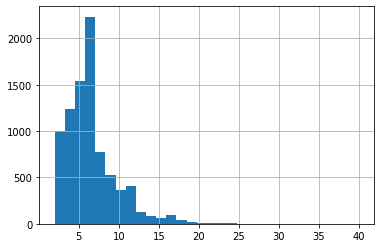

In [5]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [6]:
train_text[125]

'i mixed eggs with cream'

In [7]:
train_input[125]

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([ 101, 1045, 3816, 6763, 2007, 6949,  102,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)>

In [8]:
train_mask[125]

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)>

# Modelling

## Build and Train Model

Resources:
- BERT paper https://arxiv.org/pdf/1810.04805.pdf
- DistilBert paper: https://arxiv.org/abs/1910.01108
- DistilBert Tensorflow Documentation: https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel

In [9]:
def build_model(base_model, trainable=False, params={}):
    # TODO: build the model, with the option to freeze the parameters in distilBERT
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # Hint 1: the cls token (token for classification in bert / distilBert) corresponds to the first element in the sequence in DistilBert. Take a look at Figure 2 in BERT paper.
    # Hint 2: this guide may be helpful for parameter freezing: https://keras.io/guides/transfer_learning/
    # Hint 3: double check that your number of parameters make sense
    # Hint 4: carefully consider your final layer activation and loss function

    # Refer to https://keras.io/api/layers/core_layers/input/
    max_seq_len = 24
    inputs = Input(shape = (max_seq_len,), dtype='int64')
    masks  = Input(shape = (max_seq_len,), dtype='int64')

    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)
    # dbert_last_hidden_state gets you the output encoding for each of your tokens.ok 
    # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
    # which can be used to build a sentence classification network
    dbert_last_hidden_state = dbert_output.last_hidden_state

    
    # Explanation for dbert_last_hidden_state[:, 0, :]
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768) 
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data.



    # Any additional layers should go here
    # use the 'params' as a dictionary for hyper parameter to facilitate experimentation
    dense_layer = Dense(params['dense_layer_1_units'],activation='relu')(dbert_last_hidden_state[:, 0, :])
    dropout_layer = Dropout(params['dropout_rate_1'])(dense_layer)
    dense_layer = Dense(params['dense_layer_2_units'],activation='relu')(dropout_layer)
    #dropout_layer = Dropout(params['dropout_rate_2'])(dense_layer)
    probs = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(params['regularizer_l2_rate']), name="output")(dense_layer)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()
    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
params={# add parameters here
        "dense_layer_1_units": 128,
	      "dense_layer_2_units": 64,
        "dropout_rate_1": 0.1,
        "dropout_rate_2": 0.1,
        "regularizer_l2_rate":0.01
        }

model = build_model(dbert_model, params=params)

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_2[0][0]']                
                                one, 24, 768),                                                    
                                 hidden_states=None                                           

In [10]:
def compile_model(model):
    # TODO: compile the model, include relevant auc metrics when training
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    METRICS = [
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
    ]
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    loss = keras.losses.binary_crossentropy
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=METRICS)
    return model

model = compile_model(model)

In [11]:
import tensorflow as tf
def train_model(model, model_inputs_and_masks_train, model_inputs_and_masks_val,
    y_train, y_val, batch_size, num_epochs):
    # TODO: train the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    input_ids = train_model_inputs_and_masks['inputs']
    attention_masks = train_model_inputs_and_masks['masks']
    labels = tf.convert_to_tensor(train_y[:])
    dataset = tf.data.Dataset.from_tensors(( (input_ids, attention_masks), labels ))
    history = model.fit(dataset,
          epochs=num_epochs,
          batch_size=batch_size, verbose=1)
    
    return model, history

model, history = train_model(model, train_model_inputs_and_masks, val_model_inputs_and_masks, train_y, val_y, batch_size=128, num_epochs=5)

Epoch 1/5
1/1 [==============================] - 352s 352s/step - loss: 0.6849 - accuracy: 0.6423 - precision: 0.7025 - recall: 0.8536
Epoch 2/5
1/1 [==============================] - 350s 350s/step - loss: 0.6822 - accuracy: 0.6487 - precision: 0.7043 - recall: 0.8639
Epoch 3/5
1/1 [==============================] - 350s 350s/step - loss: 0.6817 - accuracy: 0.6494 - precision: 0.7038 - recall: 0.8673
Epoch 4/5
1/1 [==============================] - 348s 348s/step - loss: 0.6812 - accuracy: 0.6572 - precision: 0.7040 - recall: 0.8859
Epoch 5/5
1/1 [==============================] - 352s 352s/step - loss: 0.6785 - accuracy: 0.6550 - precision: 0.7015 - recall: 0.8883


# Further exploration (REMOVE ALL CODE AFTER THIS CELL BEFORE SUBMISSION)
Any code after this is not evaluated, and must be removed before submission.
Leaving code below will result in losing marks.